In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
#path = "D:/"
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'alpha': [0.001, 0.01, 0.1, 1,0.0001],
    'tol': [0.001,0.0001],
    'validation_fraction' : [0.05,0.1,0.2],
 }

In [7]:
lr_clf = GridSearchCV(Perceptron(max_iter= n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1, verbose=4, iid=True,cv=5)

In [8]:
model = lr_clf.fit(X_train_cls, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   49.3s finished


In [9]:
model.best_score_

0.6190666666666667

In [10]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'validation_fraction': 0.05, 'alpha': 0.001, 'tol': 0.001}
alpha: 0.001
tol: 0.001
validation_fraction: 0.05


In [11]:
pickle.dump(model,open("Perceptron_cls_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [12]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [13]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = CalibratedClassifierCV(Perceptron(max_iter= n_iter, n_jobs=-1,alpha=model.best_params_['alpha'],tol=model.best_params_['tol'],
                          validation_fraction=model.best_params_['validation_fraction']))

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_cls[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_cls)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_cls)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_cls)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.04 sec
Validation Accuracy: 52.05%
Validation Time:0.07 sec
Test Accuracy: 52.18%
Test Time:0.05 sec


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

(0.4730000000000013, 0.22733333333333333, 0.62)
MRR: 0.4730000000000013
MRR Time:0.65 sec
SampleSize: 500
Train Time:0.05 sec
Validation Accuracy: 55.25%
Validation Time:0.04 sec
Test Accuracy: 54.31%
Test Time:0.04 sec


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

(0.4823148148148169, 0.234, 0.6306666666666667)
MRR: 0.4823148148148169
MRR Time:0.55 sec
SampleSize: 1000
Train Time:0.11 sec
Validation Accuracy: 55.58%
Validation Time:0.04 sec
Test Accuracy: 55.49%
Test Time:0.04 sec


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

(0.4779460317460327, 0.234, 0.62)
MRR: 0.4779460317460327
MRR Time:0.53 sec
SampleSize: 10000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:1.01 sec
Validation Accuracy: 61.02%
Validation Time:0.04 sec
Test Accuracy: 61.14%
Test Time:0.04 sec
(0.5512000000000026, 0.31133333333333335, 0.732)
MRR: 0.5512000000000026
MRR Time:0.55 sec
SampleSize: 20000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:1.98 sec
Validation Accuracy: 62.51%
Validation Time:0.17 sec
Test Accuracy: 63.27%
Test Time:0.12 sec
(0.5831555555555584, 0.3586666666666667, 0.7606666666666667)
MRR: 0.5831555555555584
MRR Time:0.69 sec
SampleSize: 50000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:3.07 sec
Validation Accuracy: 63.17%
Validation Time:0.04 sec
Test Accuracy: 64.15%
Test Time:0.04 sec
(0.5878222222222247, 0.36333333333333334, 0.7673333333333333)
MRR: 0.5878222222222247
MRR Time:0.54 sec
SampleSize: 75000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/psukhapa/.conda/envs/sukha

Train Time:4.41 sec
Validation Accuracy: 64.29%
Validation Time:0.04 sec
Test Accuracy: 65.07%
Test Time:0.04 sec
(0.5967888888888915, 0.37133333333333335, 0.778)
MRR: 0.5967888888888915
MRR Time:0.54 sec
[0.5205, 0.5525, 0.5558, 0.6102, 0.6251, 0.6317, 0.6429]
[0.5218, 0.5431, 0.5549, 0.6114, 0.6327, 0.6415, 0.6507]
[0.4730000000000013, 0.4823148148148169, 0.4779460317460327, 0.5512000000000026, 0.5831555555555584, 0.5878222222222247, 0.5967888888888915]
[0.22733333333333333, 0.234, 0.234, 0.31133333333333335, 0.3586666666666667, 0.36333333333333334, 0.37133333333333335]
[0.62, 0.6306666666666667, 0.62, 0.732, 0.7606666666666667, 0.7673333333333333, 0.778]


In [16]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Accuracy_cls.png")
    plt.show()

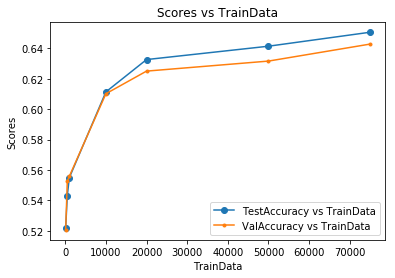

In [17]:
accuracyVisualization()

In [18]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Mrr_cls.png")
    plt.show()

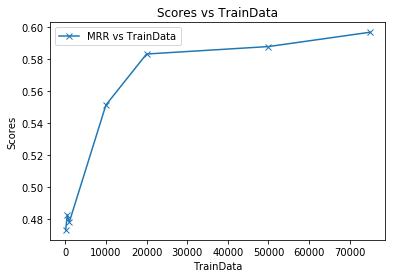

In [19]:
mrrVisualization()

In [20]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Precision_cls.png")
    plt.show()

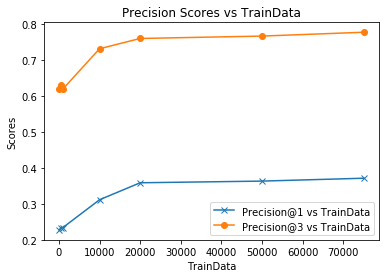

In [21]:
precisionVisualization()